In [ ]:
##### MARCO BRILLANTI #####

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing

from sklearn.preprocessing import StandardScaler

In [ ]:
# Asking permission to access Google Drive with Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
########################
#### Data Analytics ####
########################

# Loading and Reading the json files
import json

# Setting the path to the necessary files
json_path_general = '/content/drive/MyDrive/Claranet/general_log.json'
json_path_slow = '/content/drive/MyDrive/Claranet/slow_log.json'

# Read files
with open(json_path_general, 'r') as myfile:
    data_general_2 = myfile.read()

with open(json_path_slow, 'r') as myfile:
    data_slow_2 = myfile.read()

# Parse files
df_general = pd.read_json(data_general_2)
df_slow = pd.read_json(data_slow_2)

In [ ]:
# Visualise the first dataset
df_general

In [ ]:
# Visualise the second dataset
df_slow

In [ ]:
# Read the visualise the SQL file
sql_path = '/content/drive/MyDrive/Claranet/tpch.sql'

with open(sql_path,'r') as f:
  lines = [line.strip() for line in f if line.strip()]

#df_sql = pd.DataFrame(lines)
#df_sql

In [ ]:
# IMPORTANT NOTE:
# The first part of this analysis is just an introduction to the problem, in fact, as a
# first step I work on the df_general dataset (general_log.json) in order to assess
# the type of data provided and eventually identify the executing time.
# The main part of the analysis will be presented later where I will focus the analysis 
# on the second data set df_slow (slow_log.json) because it is contains the execution time (query_time).


In [ ]:
# Assessment of the time range considered in terms of date and time
df_general["event_time"].min(), df_general["event_time"].max()

(Timestamp('2021-01-14 11:20:54.509544'),
 Timestamp('2021-01-14 15:19:54.549896'))

In [ ]:
# The time range under analysis cover almost 4 hours of activity
df_general["event_time"].max() - df_general["event_time"].min()

Timedelta('0 days 03:59:00.040352')

In [ ]:
# Split the new_time column into date and time
df_general['new_date'] = [d.date() for d in df_general['event_time']]
df_general['new_time'] = pd.to_timedelta(df_general['event_time'].dt.strftime('%H:%M:%S.%f')).dt.total_seconds().astype(float)

# Delete event_time column (no more needed)
del df_general['event_time'] # instead deleting the column I can use: df_general = df_general.drop(['event_time'], axis=1)

df_general


,user_host,thread_id,server_id,command_type,argument,new_date,new_time
0,guest[guest] @ [185.9.209.177],67,97408076,Query,/* ApplicationName=DataGrip 2020.2.3 */ select...,2021-01-14,55194.549896
1,guest[guest] @ [185.9.209.177],67,97408076,Query,/* ApplicationName=DataGrip 2020.2.3 */ SET ne...,2021-01-14,55194.489750
2,guest[guest] @ [185.9.209.177],67,97408076,Query,SHOW WARNINGS,2021-01-14,55194.430215
3,guest[guest] @ [185.9.209.177],67,97408076,Query,SHOW WARNINGS,2021-01-14,55194.369984
4,guest[guest] @ [185.9.209.177],67,97408076,Query,/* ApplicationName=DataGrip 2020.2.3 */ select...,2021-01-14,55194.310359
...,...,...,...,...,...,...,...
16096,rdsadmin[rdsadmin] @ localhost [127.0.0.1],9,97408076,Query,SELECT 1,2021-01-14,40859.393914
16097,rdsadmin[rdsadmin] @ localhost [127.0.0.1],9,97408076,Query,SELECT 1,2021-01-14,40859.392965
16098,guest[guest] @ [185.9.209.177],14,97408076,Query,SELECT @@session.transaction_isolation,2021-01-14,40854.995895
16099,guest[guest] @ [185.9.209.177],14,97408076,Query,SHOW WARNINGS,2021-01-14,40854.934014


In [ ]:
# The day is always the same we can cancel the column
del df_general['new_date']


In [ ]:
# Checking the types of variables
df_general.dtypes

user_host        object
thread_id         int64
server_id         int64
command_type     object
argument         object
new_time        float64
dtype: object

In [ ]:
# Checking for the uniqueness of some features
# this process has been done on all the columns 
# here an example

df_general['server_id'].nunique()

# the server_id is always the same so we can remove the column
del df_general['server_id']

# checking for null values

#df_obj[df_obj.isnull().any(axis=1)]

In [ ]:
# Selecting of categorical columns
df_obj = df_general.select_dtypes(include=['object']).copy()

print(df_obj["user_host"].value_counts())
print(df_obj["command_type"].value_counts())
print(df_obj["argument"].value_counts())

# Eventually the following library needs to be installed
#!pip install category_encoders

# creation of a new dataframe where categorical data are converted to numerical
'''
One Hot Encoding
Label encoding has the advantage that it is straightforward but it has the disadvantage that the numeric values 
can be “misinterpreted” by the algorithms. For example, the value of 0 is obviously less than the value of 4. 

A common alternative approach is called one hot encoding. 
The basic strategy is to convert each category value into a new column and assigns a 1 or 0 (True/False) value
to the column. This has the benefit of not weighting a value improperly but does have the downside of adding more 
columns to the dataset.

Pandas supports this feature using get_dummies.
'''

df_cat = pd.get_dummies(df_obj, columns=["user_host", "command_type", "argument"])

rdsadmin[rdsadmin] @ localhost [127.0.0.1]    9473
guest[guest] @  [172.31.36.183]               6312
guest[guest] @  [185.9.209.177]                175
rdsadmin[rdsadmin] @ localhost []               90
[rdsadmin] @ localhost []                       45
[guest] @  [185.9.209.177]                       3
[guest] @  [172.31.36.183]                       3
Name: user_host, dtype: int64
Query         15957
Connect          51
Quit             48
Statistics       45
Name: command_type, dtype: int64
SELECT 1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [ ]:
# Eventually check the new dataset
#df_cat

In [ ]:
# Merge the df_cat with the processed df_general

df_new = pd.concat([df_general, df_cat], axis=1)

# remove the categorical columns
del df_new["user_host"]
del df_new["argument"]
del df_new['command_type']

# The new dimensionality of the dataset is 16101 rows × 3822 columns

# Eventually display the new dataset obtained
#df_new


In [ ]:
'''
The workflow analysed so far is going to be applied to the df_slow dataset and 
I will focus the analysis of this specific dataset
'''
# Here just a recap of the df_slow dataset
df_slow

,start_time,user_host,query_time,lock_time,rows_sent,rows_examined,db,last_insert_id,insert_id,server_id,sql_text,thread_id
0,2021-01-14 15:11:51.815988,guest[guest] @ [185.9.209.177],2021-04-20 00:00:00.000093,2021-04-20 00:00:00.000000,0,0,tpch,0,0,97408076,/* ApplicationName=DataGrip 2020.2.3 */ SET ne...,67
1,2021-01-14 15:11:51.749969,guest[guest] @ [185.9.209.177],2021-04-20 00:00:00.000055,2021-04-20 00:00:00.000000,0,0,tpch,0,0,97408076,SHOW WARNINGS,67
2,2021-01-14 15:11:51.687122,guest[guest] @ [185.9.209.177],2021-04-20 00:00:00.000076,2021-04-20 00:00:00.000000,0,0,tpch,0,0,97408076,SHOW WARNINGS,67
3,2021-01-14 15:11:51.623647,guest[guest] @ [185.9.209.177],2021-04-20 00:00:00.000138,2021-04-20 00:00:00.000000,1,1,tpch,0,0,97408076,/* ApplicationName=DataGrip 2020.2.3 */ select...,67
4,2021-01-14 15:11:51.562513,guest[guest] @ [185.9.209.177],2021-04-20 00:00:00.000090,2021-04-20 00:00:00.000000,0,0,tpch,0,0,97408076,/* ApplicationName=DataGrip 2020.2.3 */ SET SQ...,67
...,...,...,...,...,...,...,...,...,...,...,...,...
15683,2021-01-14 11:20:59.393973,rdsadmin[rdsadmin] @ localhost [127.0.0.1],2021-04-20 00:00:00.000074,2021-04-20 00:00:00.000000,1,1,,0,0,97408076,SELECT 1,9
15684,2021-01-14 11:20:59.393082,rdsadmin[rdsadmin] @ localhost [127.0.0.1],2021-04-20 00:00:00.000147,2021-04-20 00:00:00.000000,1,1,,0,0,97408076,SELECT 1,9
15685,2021-01-14 11:20:54.995957,guest[guest] @ [185.9.209.177],2021-04-20 00:00:00.000091,2021-04-20 00:00:00.000000,1,1,tpch,0,0,97408076,SELECT @@session.transaction_isolation,14
15686,2021-01-14 11:20:54.934096,guest[guest] @ [185.9.209.177],2021-04-20 00:00:00.000102,2021-04-20 00:00:00.000000,0,0,tpch,0,0,97408076,SHOW WARNINGS,14


In [ ]:
##################################
##### df_slow pre-processing #####
##################################

# Split the time columns into date and time
df_slow['start_day'] = [d.date() for d in df_slow['start_time']]
df_slow['start_time'] = pd.to_timedelta(df_slow['start_time'].dt.strftime('%H:%M:%S.%f')).dt.total_seconds().astype(float)

df_slow['query_day'] = [d.date() for d in df_slow['query_time']]
df_slow['query_time'] = pd.to_timedelta(df_slow['query_time'].dt.strftime('%H:%M:%S.%f')).dt.total_seconds().astype(float)

df_slow['lock_day'] = [d.date() for d in df_slow['lock_time']]
df_slow['lock_time'] = pd.to_timedelta(df_slow['lock_time'].dt.strftime('%H:%M:%S.%f')).dt.total_seconds().astype(float)


del df_slow['start_day'] # instead deleting the column we can use: df_slow = df_slow.drop(['start_day'], axis=1)
del df_slow['query_day']
del df_slow['lock_day']

In [ ]:
# Check for unique features

#df_slow['last_insert_id'].nunique()
#df_slow['insert_id'].nunique()

# the last_insert_id, server_id, insert_id are always the same so we can remove the columns
del df_slow['last_insert_id']
del df_slow['insert_id']
del df_slow['server_id']

In [ ]:
# Selecting of categorical column
df_obj_slow = df_slow.select_dtypes(include=['object']).copy()

print(df_obj_slow["user_host"].value_counts())
#print(df_obj_slow["db"].value_counts())
#print(df_obj_slow["sql_text"].value_counts())

rdsadmin[rdsadmin] @ localhost [127.0.0.1]    9160
guest[guest] @  [172.31.36.183]               6313
guest[guest] @  [185.9.209.177]                127
rdsadmin[rdsadmin] @ localhost []               88
Name: user_host, dtype: int64


In [ ]:
#!pip install category_encoders

# creation of a new dataframe where categorical data are converted to numerical
df_cat_slow = pd.get_dummies(df_obj_slow, columns=["user_host", "db", "sql_text"])

# Merge the df_cat with the processed df_general

df_new_slow = pd.concat([df_slow, df_cat_slow], axis=1)

# remove the categorical columns
del df_new_slow["user_host"]
del df_new_slow["db"]
del df_new_slow['sql_text']

# Visualise the df_new_slow dataset - dimensionality: 15688 rows × 3815 columns
#df_new_slow

In [ ]:
# labels = execution time
labels_slow = df_new_slow['query_time']

del df_new_slow['query_time']

labels_slow

0        0.000093
1        0.000055
2        0.000076
3        0.000138
4        0.000090
           ...   
15683    0.000074
15684    0.000147
15685    0.000091
15686    0.000102
15687    0.181089
Name: query_time, Length: 15688, dtype: float64

In [ ]:
# Checking for Null values

# df_new_slow.isnull().sum()

# No NaN values

In [ ]:
# Data Scaling for ML analysis
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
X_data = sc_x.fit_transform(df_new_slow)
# I won't use this scaled dataset directly because I have adopted an alternative technical solution (see later)
# However, the X_data dataset is ready to be analysed with any kind of ML algorithm.

In [ ]:
# Visualisation of the Scaled dataset
#X_data

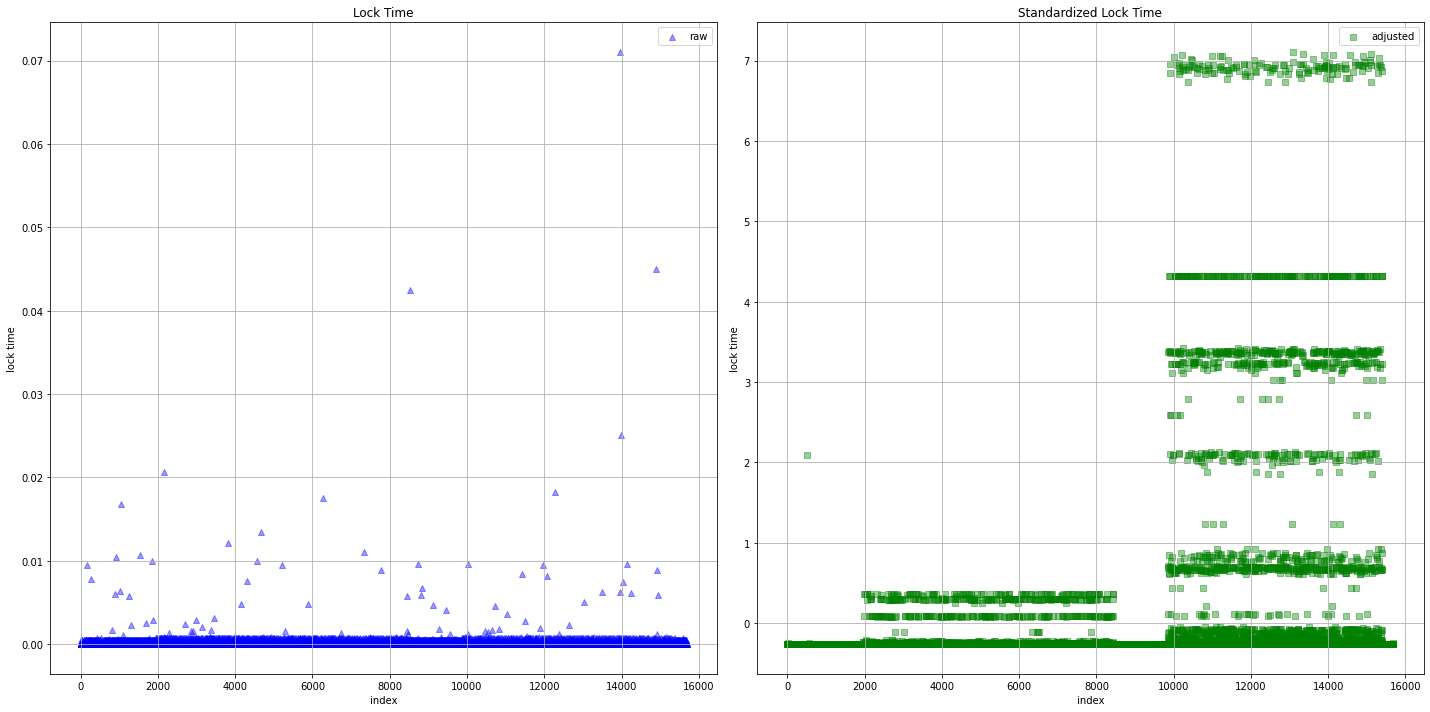

In [ ]:
# A possible visualisation to see the scaling effect
# Checking the effect of this transformation by plotting the raw data before and after the transformation. 

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 10))
c = ['blue', 'green']
m = ['^', 's']

ax1.scatter(df_new_slow.index,
            df_new_slow['lock_time'],
            color = c[0],
            label = 'raw',
            alpha = 0.4,
            marker = m[0])
ax2.scatter(df_new_slow.index,
            X_data[: , 2],
            color = c[1],
            label = 'adjusted',
            alpha = 0.4,
            marker = m[1])
  
ax1.set_title('Lock Time')
ax2.set_title('Standardized Lock Time')
for ax in (ax1, ax2):
    ax.set_xlabel('index')
    ax.set_ylabel('lock time')
    ax.legend(loc ='upper right')
    ax.grid()
  
plt.tight_layout()
plt.show()


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


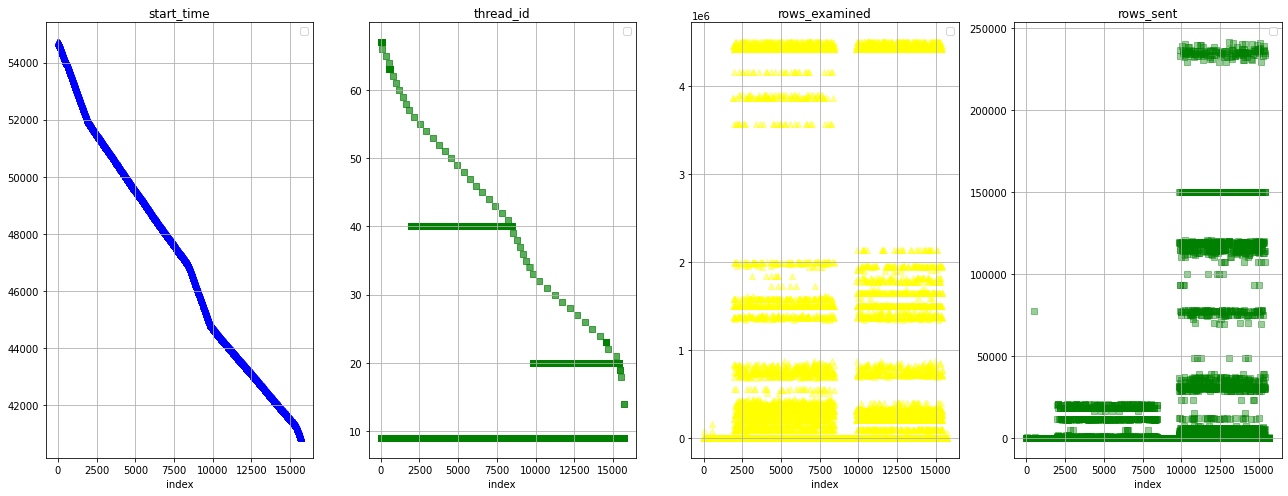

In [ ]:
# Example of a possible combined Dataset Visualisation 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize = (18, 7))
c = ['blue', 'green', 'yellow']
m = ['^', 's', 'o']

ax1.scatter(df_new_slow.index,
            df_new_slow['start_time'],
            color = c[0],
            alpha = 0.4,
            marker = m[0])
ax2.scatter(df_new_slow.index,
            df_new_slow['thread_id'],
            color = c[1],
            alpha = 0.4,
            marker = m[1])
ax3.scatter(df_new_slow.index,
            df_new_slow['rows_examined'],
            color = c[2],
            alpha = 0.4,
            marker = m[0])
ax4.scatter(df_new_slow.index,
            df_new_slow['rows_sent'],
            color = c[1],
            alpha = 0.4,
            marker = m[1])
ax1.set_title('start_time')
ax2.set_title('thread_id')
ax3.set_title('rows_examined')
ax4.set_title('rows_sent')
for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlabel('index')
    ax.legend(loc ='upper right')
    ax.grid()
  
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


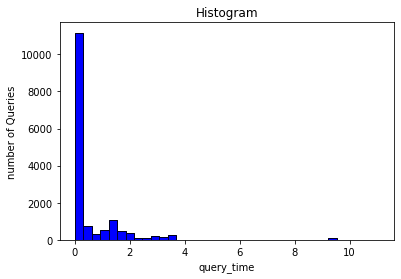

In [ ]:
'''
A function that creates a plot of the distribution for a column of the data.
'''
import seaborn as sns

def col_plot(df, name_column):
  # matplotlib histogram
  plt.hist(df[name_column], color = 'blue', edgecolor = 'black', bins = int(180/5))
  
  # seaborn histogram
  sns.distplot(df[name_column], hist=True, kde=False, bins=int(180/5), color = 'blue',
               hist_kws={'edgecolor':'black'})
  
  # Add labels
  plt.title('Histogram')
  plt.ylabel('number of Queries')
  plt.xlabel(name_column)

# Calling the function I have passed as parameters the dataset df_slow and the column called query_time
col_plot(df_slow, 'query_time')

In [ ]:
####################################
#### MULTICOLLINEARITY ANAYSIS #####
####################################

# PREPARING THE DATASET FOR THE NETWORK

# extracting feature (x) and labels (y)
x = df_new_slow
y = labels_slow


In [ ]:
# creating training, validation and testing datasets
from sklearn.model_selection import train_test_split

x_train_1 , x_test , y_train_1 , y_test = train_test_split(x , y , test_size = 0.15 , random_state = 0)
x_train , x_val , y_train , y_val = train_test_split(x_train_1 , y_train_1 , test_size = 0.05 , random_state = 0)

# Data Scaling (for the ANN)
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
x_train_new = sc_x.fit_transform(x_train)

# The same transformation needs to be applied to test and validation sets
x_test_new = sc_x.transform(x_test)
x_val_new = sc_x.transform(x_val) 

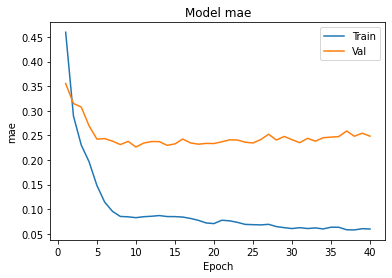

--------------------------------------------------------


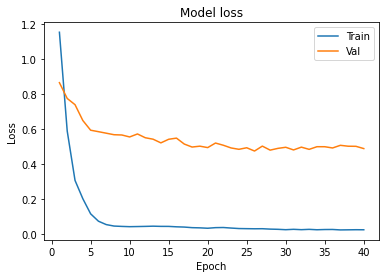

In [ ]:
'''
Train a simple model to predict extecution time using all other variables. 
Visualisation of the performance of this model.
'''
# Model 1
# BUILDING A SIMPLE MODEL
import tensorflow as tf
import tensorflow.keras as keras

epoch = 30

def plot_learningCurve(history):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  #plotting the mae vs epoch of training set
  plt.plot(epoch_range, history.history['mae'])
  #plotting the val_mae vs epoch of the validation dataset.
  plt.plot(epoch_range, history.history['val_mae'])

  plt.title('Model mae')
  plt.ylabel('mae')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc = 'upper right')
  plt.show()

  print("--------------------------------------------------------")
  
  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])

  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc = 'upper right')
  plt.show()


#### MODEL 1 ####

simple_model = keras.Sequential([
                                 keras.layers.Dense(64 , activation = 'relu' , input_shape = (3814, )),
                                 keras.layers.Dense(32 , activation = 'relu'),
                                 keras.layers.Dense(1)
                                 ])

simple_model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])

history_simple = simple_model.fit(x_train_new , y_train , 
                                  batch_size = 32,
                                  epochs = 30,
                                  verbose = 0 , 
                                  validation_data =(x_val_new , y_val))

plot_learningCurve(history_simple)


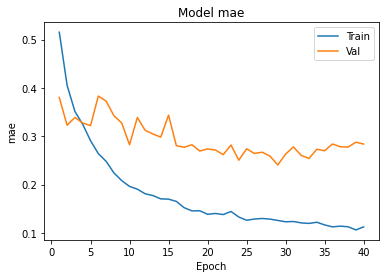

--------------------------------------------------------


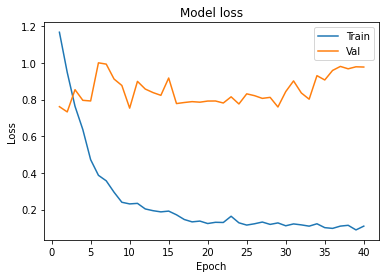

In [ ]:
'''
Train a more complex model to predict execution time and avoid overfitting (eventually)
'''
#### MODEL 2 ####
# BUILDING A COMPLEX MODEL

epoch = 40

large_model = keras.Sequential([
                                keras.layers.Dense(256 , activation = 'relu' , input_shape = (3814, )),
                                keras.layers.Dropout(0.5),
                                keras.layers.Dense(128 , activation = 'relu'),
                                keras.layers.Dropout(0.4),
                                keras.layers.Dense(128 , activation = 'relu'),
                                keras.layers.Dropout(0.3),
                                keras.layers.Dense(128 , activation = 'relu'),
                                keras.layers.Dropout(0.2),
                                keras.layers.Dense(128 , activation = 'relu'),
                                keras.layers.Dense(1)
                                ])

large_model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])

history_large = large_model.fit(x_train_new , y_train , 
                                  batch_size = 32,
                                  epochs = 40,
                                  verbose = 0 , 
                                  validation_data =(x_val_new , y_val))

plot_learningCurve(history_large)


In [ ]:
'''
The ML problem presented here is a prediction problem (Regression).
I could adopt a Linear Regression model as a simple model to predict the execution time and a Nonlinear Regression 
model as a complex model. However, I wanted to use artificial neural networks to predict the execution time just to 
show an alternative solution to the collinearity problem and also show the flexibility of the ANNs.
'''

In [ ]:
###############
# EVALUATION #
###############

# To evaluate the model’s performance, we call its predict method on the test data.
ann_predictions = large_model.predict(x_test)
#ann_predictions = simple_model.predict(x_test)

# We call r2_score of sklearn_metrics to check the performance score
from sklearn.metrics import r2_score
ann_score = r2_score(y_test,ann_predictions)
print("R2 Score of ANN model = "+"{:.4f}".format(ann_score))

'''
R^2 - a coefficient of determination is a regression score. The best
possible score is 1.0. An R^2 score of 0.0 indicates that the model is
constant that always predicts the expected value of y, disregarding the
input features. In our case, the value is NEGATIVE. R2 is negative only 
when the chosen model does not follow the trend of the data, 
so fits worse than a horizontal line.
'''

R2 Score of ANN model = -217114380688.3980


'\nR^2 - a coefficient of determination is a regression score. The best\npossible score is 1.0. An R^2 score of 0.0 indicates that the model is\nconstant that always predicts the expected value of y, disregarding the\ninput features. In our case, the value is NEGATIVE. R2 is negative only \nwhen the chosen model does not follow the trend of the data, \nso fits worse than a horizontal line.\n'

In [ ]:
'''
To get a different set of predictions, you will need to carry out several
such experiments, including a change of ANN configuration (additional
layers, using SimpleRNN, using dropouts, etc.), training for more number
of epochs, and so on. As the future cannot be really predicted with a certain accuracy, 
you will need to select the most suitable prediction from these experiments.
'''

In [ ]:
###### Model 3 -  Linear Regression Model ######

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_data, y)

#R2
reg.score(X_data, y)

##### Much better model ######

0.9968808236308988

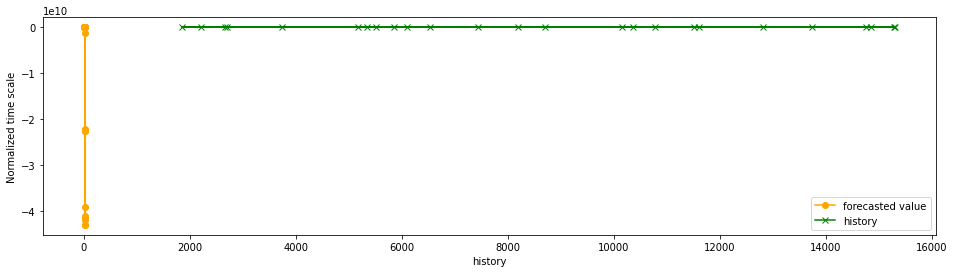

In [ ]:
# Predicting Next Data Points
'''
Now, we will use our model to predict the next data points. For this, we
extract the last 10 data points from our test data and apply our predict function
on it.
'''

X = x_test[-10:]
predictions1 = reg.predict(X)

# Plotting of the Predictions
history_data = list(y_test[-25:])
plottingvalues = list(history_data)+list(predictions1)

plt.figure(figsize = (16,4))
plt.plot(plottingvalues, color = 'orange', label = 'forecasted value',marker = 'o')
plt.plot(y_test[-25:], color = 'green', label = 'history',marker = 'x')
plt.xlabel('history')
plt.ylabel('Normalized time scale')
plt.legend()
plt.show()

In [ ]:
#### Deploy - TEST ####

import dill
import os
import pickle
import re

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)                
#tf.logging.set_verbosity(tf.logging.ERROR)

path_score = '/content/drive/MyDrive/Claranet/artifacts/ScoringService.dl'

with open(path_score, 'rb') as fout:
    s = dill.load(fout)

s.get_model('/content/drive/MyDrive/Claranet/artifacts/model.h5')

print(f"Health Check: {s.health_check()}")

print("Prediction:")
queries = ['SELECT * FROM customer', 'SELECT * FROM customer']
print(f"Queries: {queries}")


Load Vectorizer.


In [2]:
# Here we can use my linear regression model as well
#result = reg.predict(queries)

result = s.predict(queries)

print(f"Result: {result}")

'''
#standardSQL
SELECT
  *
FROM
  ML.EVALUATE(MODEL `model.h5`,
    (
    SELECT
      customer,
    FROM
      `sql_path`
    ))
'''

'\n#standardSQL\nSELECT\n  *\nFROM\n  ML.EVALUATE(MODEL `model.h5`,\n    (\n    SELECT\n      customer,\n    FROM\n      `sql_path`\n    ))\n'